In [7]:
import json
import math
import random
from dataclasses import dataclass
from typing import Any, Dict, List, Tuple, Optional


# ----------------------------
# Utils
# ----------------------------
def haversine_km(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    R = 6371.0
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dl = math.radians(lon2 - lon1)
    a = math.sin(dphi / 2) ** 2 + math.cos(p1) * math.cos(p2) * math.sin(dl / 2) ** 2
    return 2 * R * math.asin(math.sqrt(a))


def hamming(a: List[int], b: List[int]) -> int:
    return sum(1 for x, y in zip(a, b) if x != y)


# ----------------------------
# Data structures
# ----------------------------
@dataclass
class Requirement:
    req_id: str
    material_nombre: str
    categoria: str
    unidad: str
    cantidad: float


@dataclass
class Option:
    option_id: str
    id_material: str
    provedoor_id: str
    nombre_provedor: str

    sup_lat: float
    sup_lng: float
    delivery_min: int
    delivery_max: int
    rating: float

    unidad: str
    costo_unitario_mxn: float
    factor_emision: float  # kgCO2e / unidad
    co2_verified: bool
    variant: Optional[str] = None


@dataclass
class Individual:
    genes: List[int]  # gene[i] = index into options[i]
    co2_total: float = 0.0
    cost_total: float = 0.0
    dist_total: float = 0.0
    violations: int = 0
    fitness: Tuple[float, float] = (0.0, 0.0)  # lexicographic: (co2, cost)


# ----------------------------
# Parse the exact JSON format you provided
# ----------------------------
def parse_problem(problem: Dict[str, Any]):
    # requirements
    req_map: Dict[str, Requirement] = {}
    for r in problem.get("requirements", []):
        req_map[r["req_id"]] = Requirement(
            req_id=r["req_id"],
            material_nombre=r.get("material_nombre", ""),
            categoria=r.get("categoria", ""),
            unidad=r.get("unidad", ""),
            cantidad=float(r.get("cantidad", 0.0)),
        )

    # optionsByRequirement
    options_map: Dict[str, List[Option]] = {}
    for blk in problem.get("optionsByRequirement", []):
        req_id = blk["req_id"]
        opts: List[Option] = []
        for o in blk.get("options", []):
            supplier = o.get("supplier", {}) or {}
            delivery = supplier.get("delivery", {}) or {}
            offer = o.get("offer", {}) or {}

            opts.append(
                Option(
                    option_id=o.get("option_id", ""),
                    id_material=o.get("id_material", ""),
                    provedoor_id=o.get("provedoor_id", ""),
                    nombre_provedor=o.get("nombre_provedor", ""),

                    sup_lat=float(supplier.get("latitud", 0.0)),
                    sup_lng=float(supplier.get("longitud", 0.0)),
                    delivery_min=int(delivery.get("minDays", 0) or 0),
                    delivery_max=int(delivery.get("maxDays", 0) or 0),
                    rating=float(supplier.get("rating", 0.0) or 0.0),

                    unidad=offer.get("unidad", ""),
                    costo_unitario_mxn=float(offer.get("costo_unitario_mxn", 0.0)),
                    factor_emision=float(offer.get("factor_emision_kgco2e_por_unidad", 0.0)),
                    co2_verified=bool(offer.get("co2_verified", False)),
                    variant=offer.get("variant"),
                )
            )
        options_map[req_id] = opts

    site = problem.get("site", {}) or {}
    site_lat = float(site.get("latitud", 0.0))
    site_lng = float(site.get("longitud", 0.0))

    constraints = problem.get("constraints", {}) or {}
    nsga2 = problem.get("nsga2", {}) or {}

    return req_map, options_map, (site_lat, site_lng), constraints, nsga2


def build_ordered(req_map: Dict[str, Requirement], options_map: Dict[str, List[Option]]):
    # Only optimize reqs that have at least 1 option
    reqs: List[Requirement] = []
    opts_list: List[List[Option]] = []

    for req_id in sorted(req_map.keys()):
        if req_id in options_map and len(options_map[req_id]) > 0:
            reqs.append(req_map[req_id])
            opts_list.append(options_map[req_id])

    if not reqs:
        raise ValueError("No requirements with options. Add optionsByRequirement with options.")

    missing = [rid for rid in sorted(req_map.keys()) if rid not in options_map or len(options_map[rid]) == 0]
    return reqs, opts_list, missing


# ----------------------------
# Evaluation: lexicographic (CO2 first, then cost)
# ----------------------------
def get_unverified_multiplier(constraints: Dict[str, Any], default: float = 1.05) -> float:
    soft = constraints.get("soft", []) or []
    for s in soft:
        if s.get("name") == "prefer_verified_co2":
            pen = s.get("penalty", {}) or {}
            return float(pen.get("multiplier_on_total_co2", default))
    return default


def evaluate(ind: Individual,
             reqs: List[Requirement],
             options: List[List[Option]],
             site_lat: float,
             site_lng: float,
             unverified_mult: float = 1.05) -> Individual:
    co2_total = 0.0
    cost_total = 0.0
    dist_total = 0.0
    violations = 0

    for i, gene in enumerate(ind.genes):
        r = reqs[i]
        opts = options[i]
        if gene < 0 or gene >= len(opts):
            violations += 1
            continue

        o = opts[gene]

        # Hard constraint: unit match
        if o.unidad != r.unidad:
            violations += 1

        co2 = r.cantidad * o.factor_emision
        if not o.co2_verified:
            co2 *= unverified_mult

        cost = r.cantidad * o.costo_unitario_mxn
        dist = haversine_km(site_lat, site_lng, o.sup_lat, o.sup_lng)

        co2_total += co2
        cost_total += cost
        dist_total += dist

    hard_penalty = 1e12 * violations
    ind.co2_total = co2_total
    ind.cost_total = cost_total
    ind.dist_total = dist_total
    ind.violations = violations

    # Lexicographic fitness (CO2 then cost) with huge penalty if invalid
    ind.fitness = (co2_total + hard_penalty, cost_total + hard_penalty)
    return ind


# ----------------------------
# Bio-inspired operators (GA)
# ----------------------------
def random_individual(options: List[List[Option]]) -> Individual:
    genes = [random.randrange(len(opts)) for opts in options]
    return Individual(genes=genes)


def tournament_select(pop: List[Individual], k: int = 2) -> Individual:
    cand = random.sample(pop, k)
    cand.sort(key=lambda x: x.fitness)
    return cand[0]


def uniform_crossover(a: Individual, b: Individual, swap_p: float = 0.5) -> Tuple[Individual, Individual]:
    g1 = a.genes[:]
    g2 = b.genes[:]
    for i in range(len(g1)):
        if random.random() < swap_p:
            g1[i], g2[i] = g2[i], g1[i]
    return Individual(g1), Individual(g2)


def mutate(ind: Individual, options: List[List[Option]], pm: float = 0.08) -> Individual:
    g = ind.genes[:]
    for i in range(len(g)):
        if random.random() < pm:
            g[i] = random.randrange(len(options[i]))
    return Individual(g)


def dedupe(pop: List[Individual]) -> List[Individual]:
    seen = set()
    out = []
    for ind in pop:
        sig = tuple(ind.genes)
        if sig not in seen:
            seen.add(sig)
            out.append(ind)
    return out


def pick_top3_diverse(pop_sorted: List[Individual]) -> List[Individual]:
    # 1) best by fitness
    if not pop_sorted:
        return []
    picks = [pop_sorted[0]]

    # 2) ensure different genes (at least 1 difference)
    for ind in pop_sorted[1:]:
        if len(picks) == 3:
            break
        if all(hamming(ind.genes, p.genes) >= 1 for p in picks):
            picks.append(ind)

    # 3) if not enough, fill sequentially
    i = 1
    while len(picks) < 3 and i < len(pop_sorted):
        if pop_sorted[i] not in picks:
            picks.append(pop_sorted[i])
        i += 1

    return picks


# ----------------------------
# Solve: generate 3 options
# ----------------------------
def solve_top3(problem: Dict[str, Any]) -> Dict[str, Any]:
    req_map, options_map, (site_lat, site_lng), constraints, nsga2 = parse_problem(problem)
    reqs, options, missing = build_ordered(req_map, options_map)

    unverified_mult = get_unverified_multiplier(constraints, default=1.05)

    pop_size = int(nsga2.get("population_size", 120))
    generations = int(nsga2.get("generations", 150))
    pc = float(nsga2.get("crossover_probability", 0.9))
    pm = float(nsga2.get("mutation_probability", 0.08))
    tournament_k = int(nsga2.get("tournament_k", 2)) if "tournament_k" in nsga2 else 2
    seed = int(nsga2.get("seed", 42)) if "seed" in nsga2 else 42

    random.seed(seed)

    # init population
    pop = [random_individual(options) for _ in range(pop_size)]
    pop = [evaluate(ind, reqs, options, site_lat, site_lng, unverified_mult=unverified_mult) for ind in pop]

    elite_n = max(2, pop_size // 10)

    for _ in range(generations):
        pop.sort(key=lambda x: x.fitness)
        elites = pop[:elite_n]

        new_pop = elites[:]
        while len(new_pop) < pop_size:
            p1 = tournament_select(pop, k=tournament_k)
            p2 = tournament_select(pop, k=tournament_k)

            if random.random() < pc:
                c1, c2 = uniform_crossover(p1, p2)
            else:
                c1, c2 = Individual(p1.genes[:]), Individual(p2.genes[:])

            c1 = mutate(c1, options, pm=pm)
            c2 = mutate(c2, options, pm=pm)

            new_pop.append(evaluate(c1, reqs, options, site_lat, site_lng, unverified_mult=unverified_mult))
            if len(new_pop) < pop_size:
                new_pop.append(evaluate(c2, reqs, options, site_lat, site_lng, unverified_mult=unverified_mult))

        pop = new_pop

    pop = dedupe(pop)
    pop.sort(key=lambda x: x.fitness)
    top3 = pick_top3_diverse(pop)

    # decode
    def decode(ind: Individual) -> Dict[str, Any]:
        selection = []
        for i, gene in enumerate(ind.genes):
            r = reqs[i]
            o = options[i][gene]
            selection.append({
                "req_id": r.req_id,
                "material_nombre": r.material_nombre,
                "cantidad": r.cantidad,
                "unidad": r.unidad,
                "picked": {
                    "option_id": o.option_id,
                    "id_material": o.id_material,
                    "provedoor_id": o.provedoor_id,
                    "nombre_provedor": o.nombre_provedor,
                    "variant": o.variant,
                    "costo_unitario_mxn": o.costo_unitario_mxn,
                    "factor_emision_kgco2e_por_unidad": o.factor_emision,
                    "co2_verified": o.co2_verified,
                    "distance_km": round(haversine_km(site_lat, site_lng, o.sup_lat, o.sup_lng), 3),
                    "delivery": {"minDays": o.delivery_min, "maxDays": o.delivery_max},
                    "rating": o.rating
                }
            })

        return {
            "genes": ind.genes,
            "fitness_lexico": {"co2": ind.fitness[0], "cost": ind.fitness[1]},
            "metrics": {
                "total_co2e_kg": ind.co2_total,
                "total_cost_mxn": ind.cost_total,
                "total_distance_km": ind.dist_total,
                "violations": ind.violations
            },
            "selection": selection
        }

    return {
        "request_id": problem.get("request_id"),
        "optimized_req_ids": [r.req_id for r in reqs],
        "missing_req_ids": missing,
        "top3": [decode(x) for x in top3]
    }


# ----------------------------
# CLI
# ----------------------------
if __name__ == "__main__":
    # Ejecutar directamente en Jupyter o Python interactivo
    with open("nsga_input.json", "r", encoding="utf-8") as f:
        problem = json.load(f)

    result = solve_top3(problem)

    print(json.dumps(result, ensure_ascii=False, indent=2))


{
  "request_id": "REQ-2026-02-01-OBRA-001",
  "optimized_req_ids": [
    "R-001",
    "R-002",
    "R-003",
    "R-004"
  ],
  "missing_req_ids": [],
  "top3": [
    {
      "genes": [
        2,
        2,
        2,
        2
      ],
      "fitness_lexico": {
        "co2": 10067.578,
        "cost": 258850.0
      },
      "metrics": {
        "total_co2e_kg": 10067.578,
        "total_cost_mxn": 258850.0,
        "total_distance_km": 47.24080567662601,
        "violations": 0
      },
      "selection": [
        {
          "req_id": "R-001",
          "material_nombre": "Panel de yeso (tablaroca) + pasta de juntas",
          "cantidad": 154.0,
          "unidad": "m2",
          "picked": {
            "option_id": "O-003",
            "id_material": "MAT-122",
            "provedoor_id": "PROV-013",
            "nombre_provedor": "EcoYesos CDMX",
            "variant": "Baja huella",
            "costo_unitario_mxn": 98.5,
            "factor_emision_kgco2e_por_unidad": 0.612

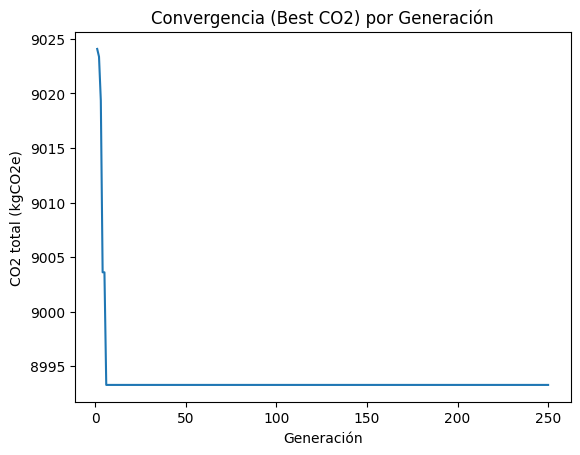

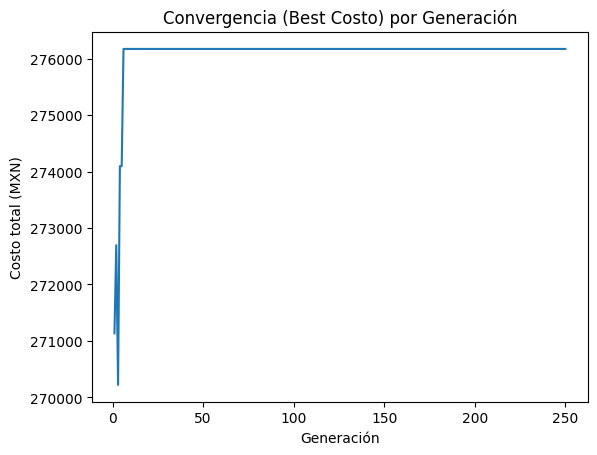

missing_req_ids: []
best final co2: 8993.29 best final cost: 276176.7


In [11]:
import json, random, math
import matplotlib.pyplot as plt

# --- Pega aquí o importa tu solver ---
# Debes tener: parse_problem(), build_ordered(), evaluate(), random_individual(),
# tournament_select(), uniform_crossover(), mutate(), dedupe(), pick_top3_diverse()
# (del script que ya tienes)

def run_with_history(problem):
    req_map, options_map, (site_lat, site_lng), constraints, nsga2 = parse_problem(problem)
    reqs, options, missing = build_ordered(req_map, options_map)

    # penalty por no verificado
    unverified_mult = 1.05
    soft = (constraints.get("soft") or [])
    for s in soft:
        if s.get("name") == "prefer_verified_co2":
            pen = s.get("penalty", {}) or {}
            unverified_mult = float(pen.get("multiplier_on_total_co2", 1.05))

    pop_size = int(nsga2.get("population_size", 120))
    generations = int(nsga2.get("generations", 150))
    pc = float(nsga2.get("crossover_probability", 0.9))
    pm = float(nsga2.get("mutation_probability", 0.08))
    seed = int(nsga2.get("seed", 42))
    tournament_k = int(nsga2.get("tournament_k", 2)) if "tournament_k" in nsga2 else 2

    random.seed(seed)

    # init pop
    pop = [random_individual(options) for _ in range(pop_size)]
    pop = [evaluate(ind, reqs, options, site_lat, site_lng, unverified_mult=unverified_mult) for ind in pop]

    elite_n = max(2, pop_size // 10)

    best_co2_hist = []
    best_cost_hist = []

    for gen in range(generations):
        pop.sort(key=lambda x: x.fitness)
        best = pop[0]
        best_co2_hist.append(best.co2_total)
        best_cost_hist.append(best.cost_total)

        elites = pop[:elite_n]
        new_pop = elites[:]

        while len(new_pop) < pop_size:
            p1 = tournament_select(pop, k=tournament_k)
            p2 = tournament_select(pop, k=tournament_k)

            if random.random() < pc:
                c1, c2 = uniform_crossover(p1, p2)
            else:
                c1, c2 = type(p1)(genes=p1.genes[:]), type(p2)(genes=p2.genes[:])

            c1 = mutate(c1, options, pm=pm)
            c2 = mutate(c2, options, pm=pm)

            new_pop.append(evaluate(c1, reqs, options, site_lat, site_lng, unverified_mult=unverified_mult))
            if len(new_pop) < pop_size:
                new_pop.append(evaluate(c2, reqs, options, site_lat, site_lng, unverified_mult=unverified_mult))

        pop = new_pop

    pop = dedupe(pop)
    pop.sort(key=lambda x: x.fitness)
    top3 = pick_top3_diverse(pop)

    return {
        "missing_req_ids": missing,
        "top3": top3,
        "history": {
            "best_co2_per_gen": best_co2_hist,
            "best_cost_per_gen": best_cost_hist
        }
    }


# --- Cargar JSON ficticio ---
with open("nsga_input_ficticio.json", "r", encoding="utf-8") as f:
    problem = json.load(f)

out = run_with_history(problem)

# --- Graficar "codo" (convergencia) ---
co2 = out["history"]["best_co2_per_gen"]
cost = out["history"]["best_cost_per_gen"]
gens = list(range(1, len(co2) + 1))

plt.figure()
plt.plot(gens, co2)
plt.title("Convergencia (Best CO2) por Generación")
plt.xlabel("Generación")
plt.ylabel("CO2 total (kgCO2e)")
plt.show()

plt.figure()
plt.plot(gens, cost)
plt.title("Convergencia (Best Costo) por Generación")
plt.xlabel("Generación")
plt.ylabel("Costo total (MXN)")
plt.show()

print("missing_req_ids:", out["missing_req_ids"])
print("best final co2:", co2[-1], "best final cost:", cost[-1])
